# Hopfield network of pattern recognition

Hopfield networks are a kind of recurrent neural network that model auto-associative memory: the ability to recall a memory from just a partial piece of that memory.

In [1]:
import os
import numpy as np
import imageio
import matplotlib
from matplotlib import pyplot as plt
from scipy.misc import imread, imsave

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

np.random.seed(1)

Let's load in a meme. I'm partial to ['Deal with it'](https://a1.memecaptain.com/src_thumbs/22990.jpg).

In [2]:
deal = imread('small-deal-with-it-with-text.jpg', mode="L")
print(deal.shape)
deal = deal.astype(int)

(128, 128)


In [3]:
np.unique(deal)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 18

To convert this to a 1 bit image, I convert everything darker than some threshold to black (1), and everything else to white (-1). Experimenting a bit with the particular image of the 'deal with it meme' that I have, a threshold of 80 seemed to work reasonably. The resulting image is still a bit rough around the edges, but it's recognizable.

In [4]:
bvw_threshold = 80

deal[deal <= bvw_threshold] = -1
deal[deal >  bvw_threshold] = 1
deal = -deal
deal

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ..., 
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [5]:
np.unique(deal)

array([-1,  1])

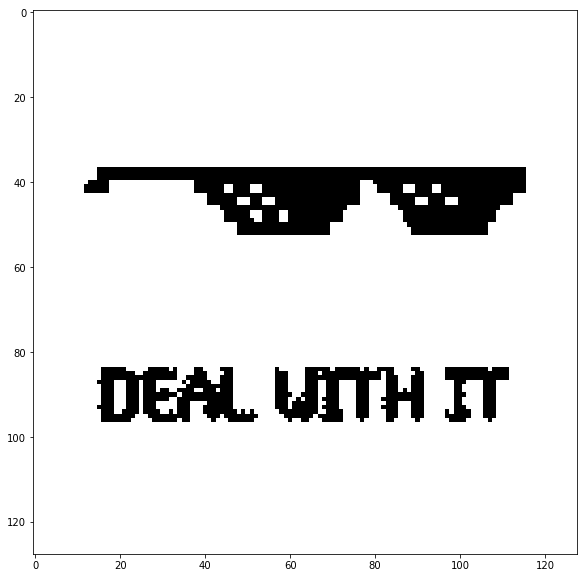

In [6]:
plt.imshow(deal, cmap='Greys', interpolation='nearest')
plt.show()

Now train the weights. Whereas before we used Hebb's rule, now let's use the Storkey Learning Rule. This rule has a few nice advantages over Hebb's rule: it allows the network to learn more patterns, its basins of attraction (to the stored patterns) are larger, the distribution of basin sizes is more even, and the shapes of the basins are more round. The weights at time `v` are:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/e0b194a405a470e54aacef9e75ced89d02f60844)

where
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c0e9c85f5bbf569acdfc8dd7ab8cccb742a0f856)

and `n` is the number of neurons and epsilon is a bit (+1 or -1) of pattern `v`.

The second term of the rule is basically the Hebbian rule. The third and fourth terms basically account for the net input to neurons j and i using the current weights.

In [7]:
def storkey_rule(pattern, old_weights=None):

    mem = pattern.flatten()
    n = len(mem)
    
    if type(old_weights) == type(None):
        new_weights = np.outer(mem,mem) - np.identity(n)
        return new_weights

    hebbian_term  = np.outer(mem,mem) - np.identity(n)

    net_inputs    = old_weights.dot(mem) #equivalent to (but faster than?) np.matmul(old_weights, mem)
    
    # I think pre_synpatic can stay put...
    pre_synaptic  = np.outer(mem,net_inputs)
    
    # but post-synaptic has to be changed somehow....?
    post_synaptic = pre_synaptic.T #equivalent to np.outer(net_inputs,mem)
    
    new_weights = old_weights + (1./n)*(hebbian_term - pre_synaptic - post_synaptic)
    
    return new_weights

**This next cell can take a little while if the image is large...**

In [8]:
deal_weights = storkey_rule(deal, old_weights=None)

Now start with a noisy version of the image. We'll just flip a certain number of random pixels on each row of the image.

In [9]:
def noisify(pattern, numb_flipped=30):

    noisy_pattern = pattern.copy()

    for idx, row in enumerate(noisy_pattern):
        choices = np.random.choice(range(len(row)), numb_flipped)
        noisy_pattern[idx,choices] = -noisy_pattern[idx,choices]
        
    return noisy_pattern

noisy_deal = noisify(pattern=deal)

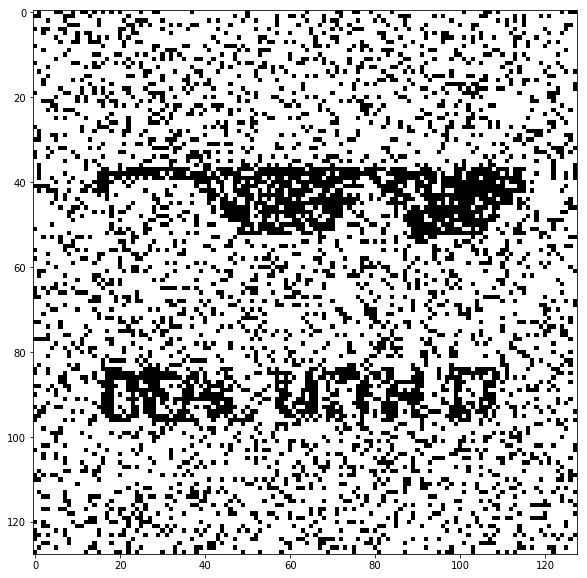

In [10]:
plt.imshow(noisy_deal, cmap='Greys', interpolation='nearest')
plt.show()

Now we can start with that, and use the weights to update it. We'll update the units asynchronously (one at a time).

In [11]:
def flow(pattern, weights, theta=0, steps = 50000):
    
    pattern_flat = pattern.flatten()

    for _ in range(steps):
        unit = np.random.randint(low=0, high=(len(pattern_flat)-1))
        unit_weights = weights[unit,:]
        net_input = np.dot(unit_weights,pattern_flat)
        pattern_flat[unit] = 1 if (net_input > theta) else -1
    
    evolved_pattern = np.reshape(a=pattern_flat, newshape=(pattern.shape[0],pattern.shape[1]))
    
    return evolved_pattern

In [12]:
steps = 50000
theta = 0

noisy_deal_evolved = flow(noisy_deal, deal_weights, theta = theta, steps = steps)

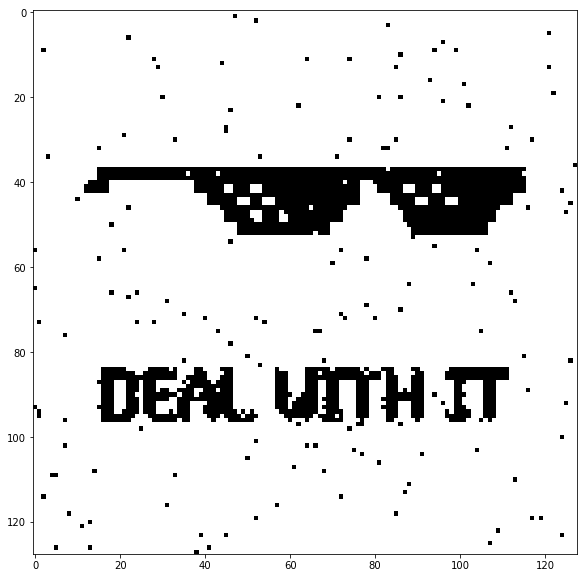

In [13]:
plt.imshow(noisy_deal_evolved, cmap='Greys', interpolation='nearest')
plt.show()

Voila.

## Training the network on a second pattern

The cooler thing about the Hopfield networks is that they can encode multiple patterns (to a limit depending on the training regimen, and the number of units). So let's try another maymay.

I got the next meme from [here](https://68.media.tumblr.com/avatar_0f24a9a67d83_128.png), and then tweaked its levels in Mac's preview so that it'd translate nicely to a 1 bit (black or white) image.

In [14]:
woah = imread('woah.png', mode="L")
woah = woah.astype(int)
woah[woah >= 1] = 1
woah[woah < 1] = -1
woah = -woah

In [15]:
np.unique(woah)

array([-1,  1])

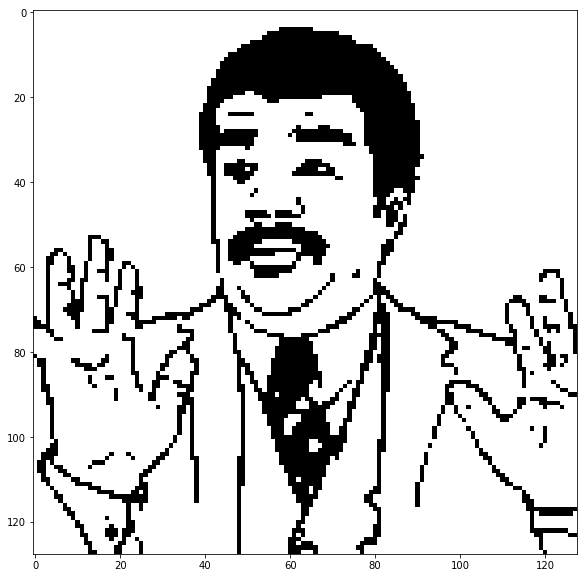

In [16]:
plt.imshow(woah, cmap='Greys', interpolation='nearest')
plt.show()

Cool. So now we make some weights for this image. The takes a little bit longer than the Hebbian learning rule when it is dealing with previous, nonzero weights.

In [18]:
average_weights = storkey_rule(woah, old_weights=deal_weights)

Now, let's make a noisy Neil deGrasse Tyson, and have the network try to recover the clean, pristine NGT.

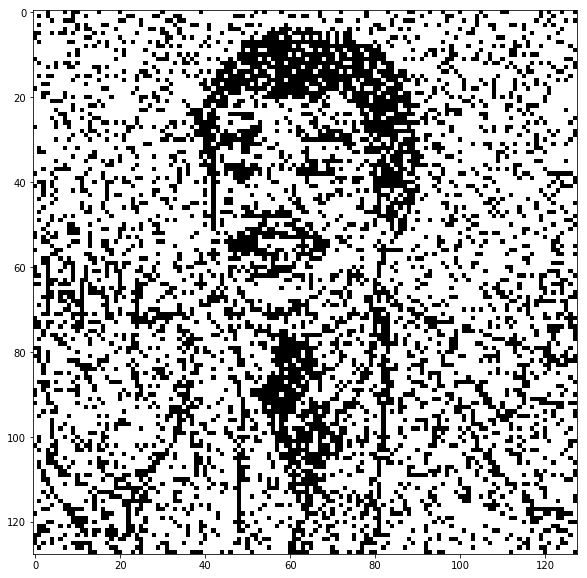

In [19]:
noisy_woah = noisify(pattern=woah)
        
plt.imshow(noisy_woah, cmap='Greys', interpolation='nearest')
plt.show()

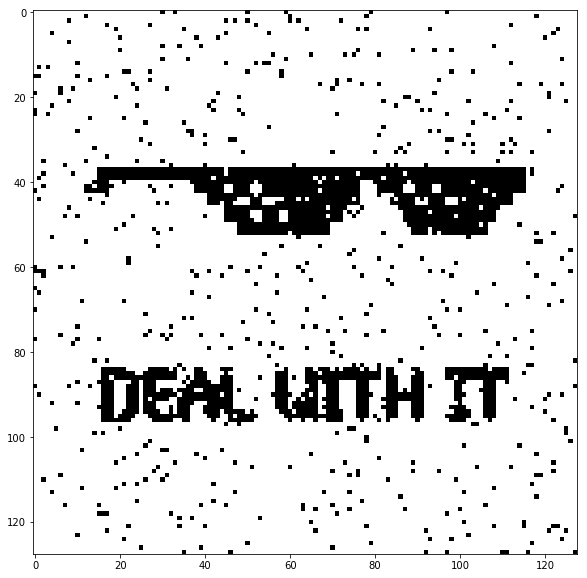

In [20]:
recovered_woah = flow(noisy_woah, average_weights, theta = theta, steps = steps)

plt.imshow(recovered_woah, cmap='Greys', interpolation='nearest')
plt.show()

Now let's doublecheck that the average weights also still work for the 'deal with it' image.

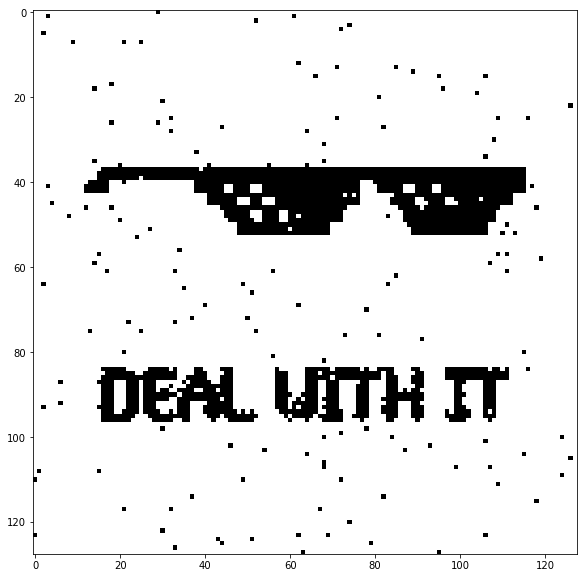

In [25]:
deal_recovered = flow(noisy_deal, average_weights, theta = theta, steps = steps)

plt.imshow(deal_recovered, cmap='Greys', interpolation='nearest')
plt.show()

Sweet. So *now* we can try something like feeding it a pattern that is halfway between the two patterns -- it should eventually settle into one of them! Who has greater meme strength!??!

In [26]:
deal_with_neil = (woah + deal) / 2
print(np.unique(deal_with_neil))

[-1.  0.  1.]


I could force those 0 values to -1 or 1, but that biases the pattern towards deal and neil, respectively (at least, testing suggested this -- I think because Neil has more black pixels and Deal has more white pixels). So, I'll leave them in. I *could* probably solve this by randomly setting 0's to 1 or -1, but naw.

In [27]:
#deal_with_neil[deal_with_neil == 0] = -1
#np.unique(deal_with_neil)

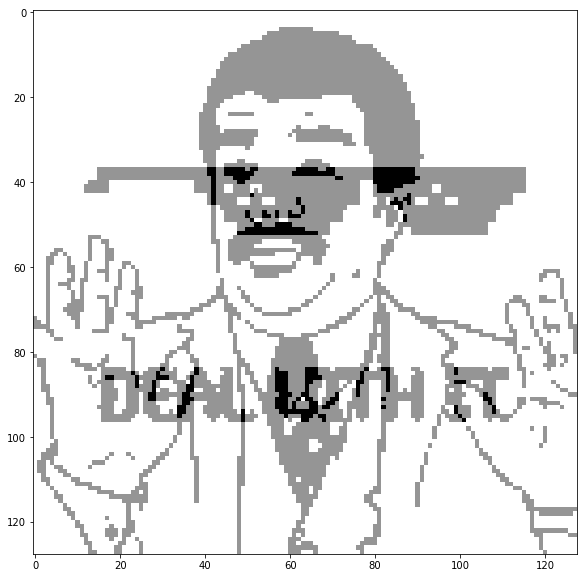

In [28]:
plt.imshow(deal_with_neil, cmap='Greys', interpolation='nearest')
plt.show()

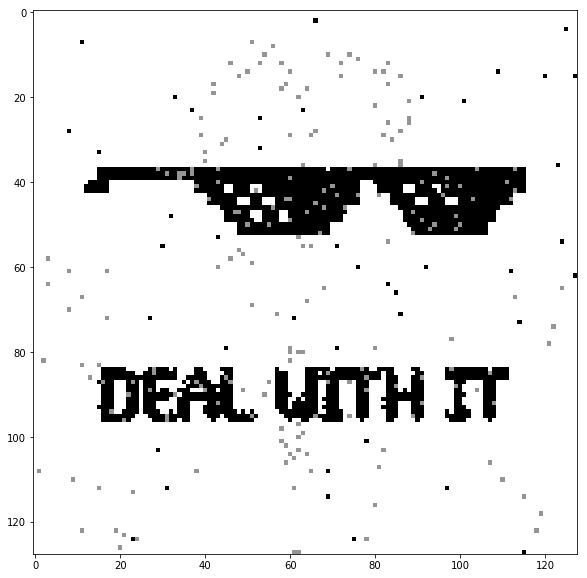

In [29]:
recovered_deal_with_neil = flow(deal_with_neil, average_weights, theta = theta, steps = steps)

plt.imshow(recovered_deal_with_neil, cmap='Greys', interpolation='nearest')
plt.show()

*Assuming the cells/pixels of 0 were unaltered*, if you run that a few times, you'll notice that sometimes it settles on Neil, and sometimes it settles on Deal!!!

## Spurious patterns

Hopfield networks can also settle onto 'spurious patterns' (patterns that the network wasn't trained on). For each stored pattern `x`, `-x` is a spurious pattern. But also, any linear combination of the of the learned patterns can be a spurious pattern. So let's learn a third pattern, and then see the network stabilize on a simple combination of the three patterns.

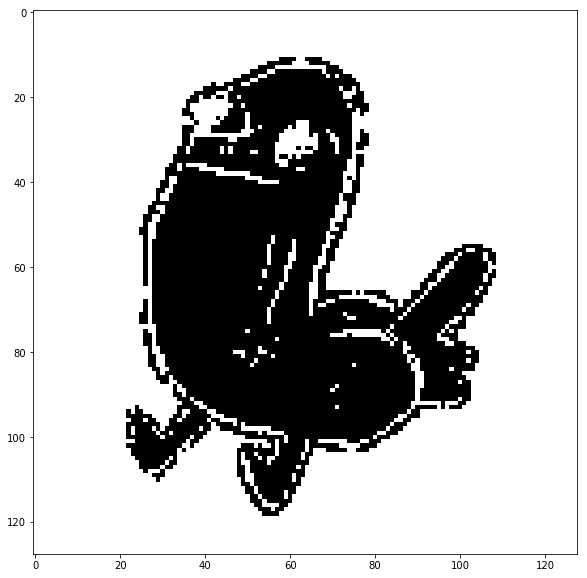

In [30]:
butt = imread('dick_butt.png', mode="L")
butt = butt.astype(int)
butt[butt >= 1] = 1
butt[butt < 1] = -1

plt.imshow(butt, cmap='Greys', interpolation='nearest')
plt.show()

In [34]:
average_weights = storkey_rule(butt, old_weights=average_weights)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


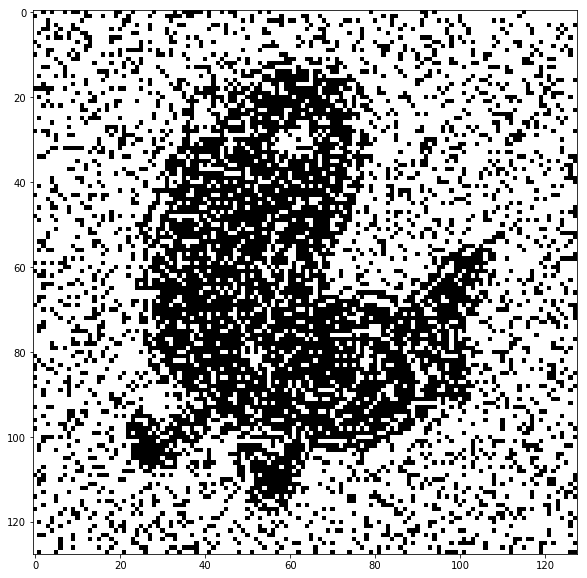

In [35]:
noisy_butt = noisify(pattern=butt)
        
plt.imshow(noisy_butt, cmap='Greys', interpolation='nearest')
plt.show()

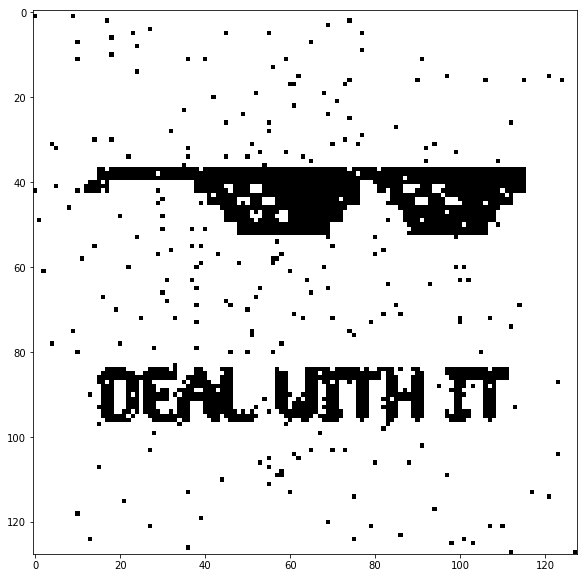

In [36]:
recovered_butt = flow(noisy_butt, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_butt, cmap='Greys', interpolation='nearest')
plt.show()

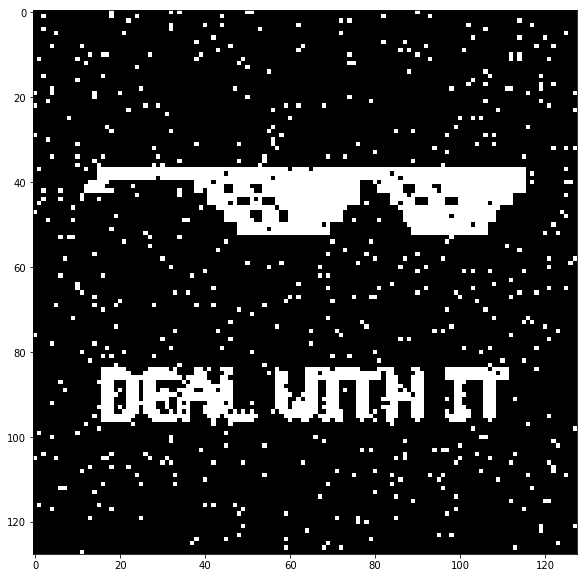

In [37]:
recovered_woah = flow(noisy_woah, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_woah, cmap='Greys', interpolation='nearest')
plt.show()

Okay, now let's make a spurious pattern. Any linear combination will do.

In [38]:
spurious_meme = butt + deal + woah
np.unique(spurious_meme)

array([-3, -1,  1,  3])

In [39]:
spurious_meme[spurious_meme > 0] = 1
spurious_meme[spurious_meme < 0] = -1

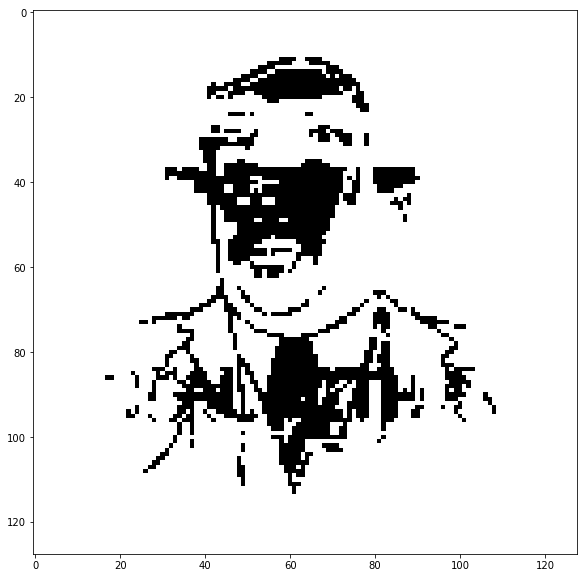

In [40]:
plt.imshow(spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

Pretty noisy. Only Neal, and kiiiiinda the Deal with It, are visible. Now make a noisy version of that combination.

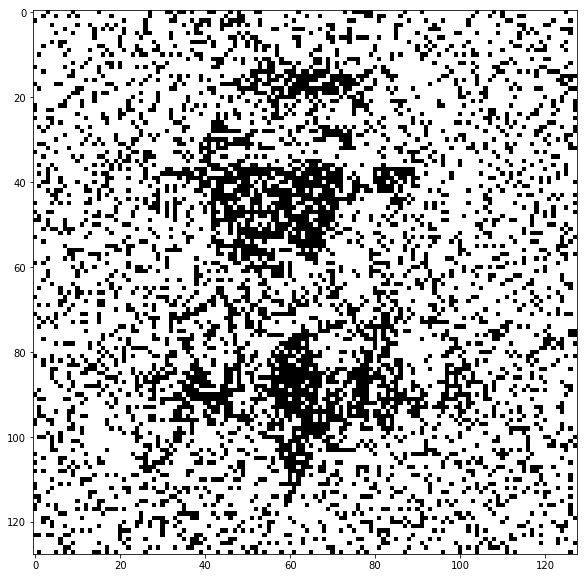

In [41]:
noisy_spurious_meme = noisify(pattern=spurious_meme)
        
plt.imshow(noisy_spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

Beautifully noisy. Can barely see anything in it. But now if we start with that, and apply the weights, it should recover the spurious pattern!

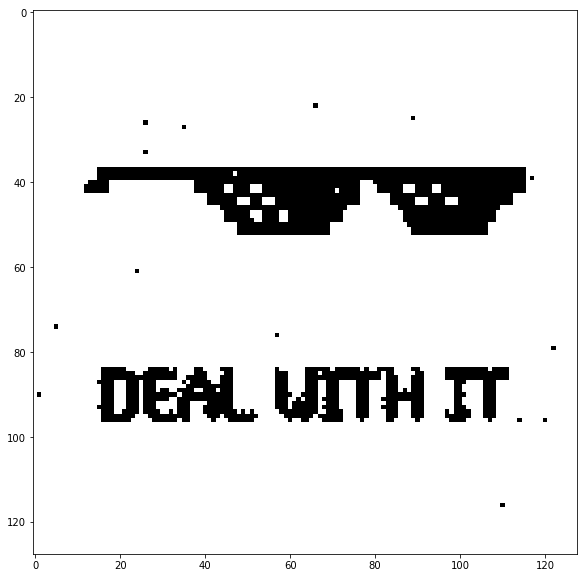

In [42]:
steps = 100000

recovered_spurious_meme = flow(noisy_spurious_meme, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_spurious_meme, cmap='Greys', interpolation='nearest')
plt.show()

And it sure as heck did.

** For now, raise an exception on the next line so that the below lines don't execute when we 'run all'.**

In [43]:
raise Exception

Exception: 

## Animations

Let's make some nifty animations of the networks recovering a pattern (learned or spurious) from an input. Let's make the input more or less pure noise, by increasing `numb_flipped`.

In [ ]:
noise = noisify(pattern=woah, numb_flipped=100)

plt.imshow(noise, cmap='Greys', interpolation='nearest')
plt.show()

Great. That sure looks like pure noise.

In [ ]:
steps = 50000

recovered_meme = flow(noise, average_weights, theta=theta, steps=steps)

plt.imshow(recovered_meme, cmap='Greys', interpolation='nearest')
plt.show()

Given that the the noise is basically a random image, the network could settle on any of the attractors (modulo *how* attractive they each are), so the above image will vary from run to run.

In [ ]:
steps = 50000
noisy_meme_flat = noise.flatten()
os.chdir('recovery_steps')

for step in range(steps):
    unit = np.random.randint(low=0, high=(len(noisy_meme_flat)-1))
    unit_weights = average_weights[unit,:]
    net_input = np.dot(unit_weights,noisy_meme_flat)

    noisy_meme_flat[unit] = 1 if (net_input > theta) else -1

    recovered_meme = np.reshape(a=noisy_meme_flat, newshape=(len(butt),len(butt)))
    if not (step % 1000):
        imsave('recovered_meme{:05d}.jpg'.format(step), recovered_meme)

In [ ]:
filenames = [x for x in os.listdir() if x[-4:] == '.jpg']
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
os.chdir("..")
imageio.mimsave('meme_movie.gif', images, duration=0.2)

<img src="meme_movie.gif" alt="Drawing" style="width: 400px;"/>